## Import Libs

In [1]:
import os
import cv2
import glob
import random
import numpy as np

from PIL import Image
import skimage.measure
from skimage import data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.morphology import disk
from skimage.util import img_as_ubyte

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score


## DATASET



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_dir = "/content/drive/MyDrive/TCC - Parte II/"
dataset_path = main_dir + "Brain Tumor Classification Dataset"

###Getting Info from dataset

In [5]:
train_glioma = glob.glob(dataset_path + "/Training/glioma_tumor/*.jpg")
train_menignioma = glob.glob(dataset_path + '/Training/meningioma_tumor/*.jpg')
train_pituitary = glob.glob( dataset_path + '/Training/pituitary_tumor/*.jpg')
train_no = glob.glob(dataset_path + '/Training/no_tumor/*.jpg')

#Test
test_glioma = glob.glob( dataset_path + '/Testing/glioma_tumor/*.jpg')
test_menignioma = glob.glob(dataset_path +  '/Testing/meningioma_tumor/*.jpg')
test_pituitary = glob.glob(dataset_path + '/Testing/pituitary_tumor/*.jpg')
test_no = glob.glob(dataset_path + '/Testing/no_tumor/*.jpg')


In [6]:
train_glioma_number = len(train_glioma)
train_menignioma_number = len(train_menignioma)
train_pituitary_number = len(train_pituitary)
train_no_number = len(train_no)

test_glioma_number = len(test_glioma)
test_menignioma_number = len(test_menignioma)
test_pituitary_number = len(test_pituitary)
test_no_number = len(test_no)

print("Number of train_glioma: ",train_glioma_number)
print("Number of train_menignioma: ",train_menignioma_number)
print("Number of train_pituitary: ",train_pituitary_number)
print("Number of train_no: ",train_no_number)
print("Number of test_glioma: ",test_glioma_number)
print("Number of test_menignioma: ",train_menignioma_number)
print("Number of test_pituitary: ",train_pituitary_number)
print("Number of test_no: ",train_no_number)

Number of train_glioma:  826
Number of train_menignioma:  822
Number of train_pituitary:  827
Number of train_no:  395
Number of test_glioma:  100
Number of test_menignioma:  822
Number of test_pituitary:  827
Number of test_no:  395


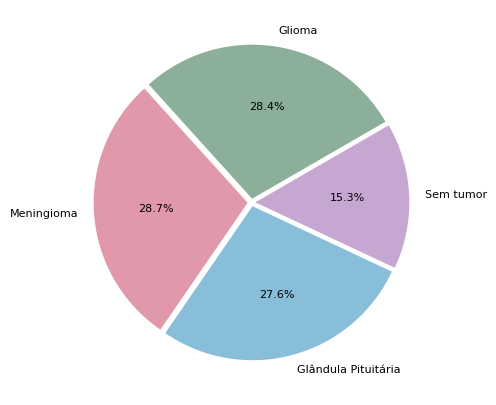

In [7]:
full_glioma = train_glioma_number + test_glioma_number
full_no_tumor = train_no_number + test_no_number
full_menignioma = train_menignioma_number + test_menignioma_number
full_pituitary = train_pituitary_number + test_pituitary_number

plt.figure(figsize=(5,5))
colors = ['#8CAF99','#E198AB',"#89BEDB","#C6A7D2"]
labels = ['Glioma', 'Meningioma', 'Glândula Pituitária', 'Sem tumor']

plt.rcParams.update({'font.size': 8})
plt.pie([full_glioma,
         full_menignioma,full_pituitary,full_no_tumor],
        labels=labels,
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);
# plt.savefig("Distribuição do dataset.png", dpi=300)


##Pre Processing

In [8]:
import cv2
import os

def resize_images(dataset_path, output_path, target_size=(256, 256)):
    """
    Redimensiona todas as imagens em um dataset para o mesmo tamanho.

    Parâmetros:
    - dataset_path: Caminho para o diretório que contém as imagens do dataset.
    - output_path: Caminho para o diretório de saída onde as imagens redimensionadas serão salvas.
    - target_size: Tupla representando o tamanho desejado das imagens (largura, altura).

    Retorna:
    - None
    """

    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_path, exist_ok=True)

    # Lista todos os arquivos no diretório do dataset
    image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

    for image_file in image_files:
      add_pixels = 0
      # Caminho completo da imagem original
      input_image_path = os.path.join(dataset_path, image_file)
      # Carregue a imagem
      img = cv2.imread(input_image_path)
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



      thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
      # find contours in thresholded image, then grab the largest one
      cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      c = max(cnts, key=cv2.contourArea)
      # find the extreme points
      extLeft = tuple(c[c[:, :, 0].argmin()][0])
      extRight = tuple(c[c[:, :, 0].argmax()][0])
      extTop = tuple(c[c[:, :, 1].argmin()][0])
      extBot = tuple(c[c[:, :, 1].argmax()][0])

      # create a new image by cropping the region defined by extreme points
      new_img = img[extTop[1] - add_pixels:extBot[1] + add_pixels, extLeft[0] - add_pixels:extRight[0] + add_pixels].copy()


      #Carrega a imagem
      resized_img = cv2.resize(new_img, target_size)


      # Redimensione a imagem


      # Crie o caminho de saída e salve a imagem redimensionada
      output_image_path = os.path.join(output_path, image_file)
      cv2.imwrite(output_image_path, resized_img)


# Exemplo de uso
main_dir = "/content/drive/MyDrive/TCC - Parte II/"
dataset_path = main_dir + "Brain Tumor Classification Dataset"




In [9]:

##Testing

glioma_dataset = dataset_path + "/Testing/glioma_tumor"
glioma_output = dataset_path + "/preprocessing" + "/Testing/glioma_tumor"

resize_images(glioma_dataset, glioma_output, target_size=(256, 256))

meningioma_dataset = dataset_path + "/Testing/meningioma_tumor"
meningioma_output = dataset_path + "/preprocessing" + "/Testing/meningioma_tumor"

resize_images(meningioma_dataset, meningioma_output, target_size=(256, 256))

no_tumor_dataset = dataset_path + "/Testing/no_tumor"
no_tumor_output = dataset_path + "/preprocessing" + "/Testing/no_tumor"

resize_images(no_tumor_dataset, no_tumor_output, target_size=(256, 256))

pituitary_dataset = dataset_path + "/Testing/pituitary_tumor"
pituitary_output = dataset_path + "/preprocessing" + "/Testing/pituitary_tumor"

resize_images(pituitary_dataset, pituitary_output, target_size=(256, 256))

#############

glioma_dataset = dataset_path + "/Training/glioma_tumor"
glioma_output = dataset_path + "/preprocessing" + "/Training/glioma_tumor"

resize_images(glioma_dataset, glioma_output, target_size=(256, 256))

meningioma_dataset = dataset_path + "/Training/meningioma_tumor"
meningioma_output = dataset_path + "/preprocessing" + "/Training/meningioma_tumor"

resize_images(meningioma_dataset, meningioma_output, target_size=(256, 256))

no_tumor_dataset = dataset_path + "/Training/no_tumor"
no_tumor_output = dataset_path + "/preprocessing" + "/Training/no_tumor"

resize_images(no_tumor_dataset, no_tumor_output, target_size=(256, 256))

pituitary_dataset = dataset_path + "/Training/pituitary_tumor"
pituitary_output = dataset_path + "/preprocessing" + "/Training/pituitary_tumor"

resize_images(pituitary_dataset, pituitary_output, target_size=(256, 256))



## Building the model

In [10]:
def validate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    val_loss = 0.0
    all_val_outputs = []
    all_val_targets = []

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            # Mova os dados para o dispositivo
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

            # Obtenha as previsões do modelo
            val_outputs = model(val_inputs)

            # Calcule a perda
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            all_val_outputs.append(val_outputs)
            all_val_targets.append(val_targets)

    val_loss /= len(val_loader)

    val_outputs = torch.cat(all_val_outputs, dim=0)
    val_targets = torch.cat(all_val_targets, dim=0)

    # Mova as previsões e alvos para a CPU para calcular a acurácia
    val_outputs_cpu = val_outputs.cpu()
    val_predictions = torch.argmax(val_outputs_cpu, axis=1)
    val_targets_cpu = val_targets.cpu()

    # Calcula as previsões e acurácia
    val_accuracy = accuracy_score(val_targets_cpu.numpy(), val_predictions.numpy())

    return val_loss, val_accuracy


In [11]:

# Verifique se o ambiente do Google Colab possui GPU habilitada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transformações de pré-processamento das imagens
# Verificar Melhor isso

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar o conjunto de dados
train_dataset = datasets.ImageFolder(root= dataset_path + '/Training', transform = transform)
val_dataset = datasets.ImageFolder(root = dataset_path + '/Testing', transform = transform)

# Definir DataLoader para carregar os dados em lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)




# Definir arquitetura da rede neural
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)
        x = self.fc1(x)
        return x

# Instanciar o modelo
model = SimpleCNN(num_classes=4).to(device)

# Definir a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validação
    val_loss, val_accuracy = validate_model(model, val_loader, criterion)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}')


torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, main_dir + 'Models/modelo_treinado.pth')

print("Treinamento concluído.")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Obtém informações sobre o dispositivo
print("Dispositivo atual:", device)
print("Nome do dispositivo:", torch.cuda.get_device_name(device) if device.type == "cuda" else "CPU")
print("Capacidade de computação da GPU:", torch.cuda.get_device_capability(device) if device.type == "cuda" else "N/A")
print("Número de GPUs disponíveis:", torch.cuda.device_count() if torch.cuda.is_available() else 0)